In [ ]:
# Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import os
import io
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.recurrent import LSTM
from keras.layers.merge import add
from keras.layers.embeddings import Embedding
np.random.seed(42)
import tensorflow as tf
from keras.models import load_model 

In [ ]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/My Drive/DPProject')

### Data

In [ ]:
# Data directory

DATADIR = 'UCI_HAR_Dataset'


In [ ]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [ ]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            #_read_csv(filename).as_matrix()
            _read_csv(filename).to_numpy()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [ ]:

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).to_numpy()

In [ ]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [ ]:
# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 32

In [ ]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [ ]:
# Loading the train and test data
X_train, X_test, y_train, y_test = load_data()

In [ ]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


In [ ]:
print(len(X_test))
print(len(y_train))
print(len(y_test))


2947
7352
2947


- Defining the Architecture of LSTM

In [ ]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                5376      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compiling the model 
## multi class classification
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [ ]:
#tf.keras.backend.clear_session()


In [ ]:
# Training the model
history= model.fit(X_train,
          y_train,
          batch_size=batch_size,
          validation_data=(X_test, y_test),
          epochs=epochs)

Epoch 1/30
460/460 [==============================] - 4s 9ms/step - loss: 1.2610 - accuracy: 0.4976 - val_loss: 0.9638 - val_accuracy: 0.6281
Epoch 2/30
460/460 [==============================] - 4s 8ms/step - loss: 0.8944 - accuracy: 0.6193 - val_loss: 0.8874 - val_accuracy: 0.5660
Epoch 3/30
460/460 [==============================] - 4s 8ms/step - loss: 0.7507 - accuracy: 0.6601 - val_loss: 0.8157 - val_accuracy: 0.6006
Epoch 4/30
460/460 [==============================] - 4s 8ms/step - loss: 0.6851 - accuracy: 0.6919 - val_loss: 0.6947 - val_accuracy: 0.7279
Epoch 5/30
460/460 [==============================] - 4s 8ms/step - loss: 0.5816 - accuracy: 0.7884 - val_loss: 0.7826 - val_accuracy: 0.7462
Epoch 6/30
460/460 [==============================] - 4s 8ms/step - loss: 0.4748 - accuracy: 0.8607 - val_loss: 0.6845 - val_accuracy: 0.7930
Epoch 7/30
460/460 [==============================] - 4s 8ms/step - loss: 0.3678 - accuracy: 0.8900 - val_loss: 0.5308 - val_accuracy: 0.8582
Epoch 

In [ ]:

model.save("/content/drive/MyDrive/DPProject/Model/model1.h5") 

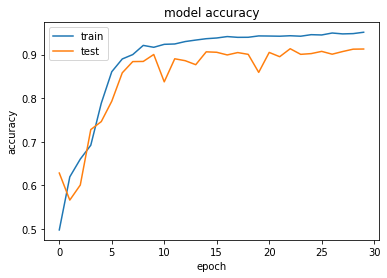

In [ ]:
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



In [ ]:

# Configuring the parameters

input = Input(shape=(timesteps, input_dim))
lstm = LSTM(n_hidden, return_sequences = True)(input)
lstm1 = LSTM(n_hidden, return_sequences = True)(lstm)
lstm2 = LSTM(n_hidden, return_sequences = False)(lstm1)

dropout=Dropout(0.2)(lstm2)
# Adding a dropout layer
dense = Dense(n_classes, activation='sigmoid')(dropout)
# Adding a dense output layer with sigmoid activation
model2=Model(inputs=input,outputs=dense)
model2.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 9)]          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128, 32)           5376      
_________________________________________________________________
lstm_2 (LSTM)                (None, 128, 32)           8320      
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 198       
Total params: 22,214
Trainable params: 22,214
Non-trainable params: 0
__________________________________________________

In [ ]:
model2.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [ ]:
history1= model2.fit(X_train,
          y_train,
          batch_size=batch_size,
          validation_data=(X_test, y_test),
          epochs=epochs)

Epoch 1/30
460/460 [==============================] - 9s 20ms/step - loss: 1.0366 - accuracy: 0.5567 - val_loss: 0.8333 - val_accuracy: 0.6098
Epoch 2/30
460/460 [==============================] - 8s 18ms/step - loss: 0.5885 - accuracy: 0.7890 - val_loss: 0.5881 - val_accuracy: 0.8073
Epoch 3/30
460/460 [==============================] - 8s 18ms/step - loss: 0.3514 - accuracy: 0.8927 - val_loss: 0.5063 - val_accuracy: 0.8395
Epoch 4/30
460/460 [==============================] - 8s 18ms/step - loss: 0.2371 - accuracy: 0.9168 - val_loss: 0.3562 - val_accuracy: 0.8897
Epoch 5/30
460/460 [==============================] - 8s 18ms/step - loss: 0.2006 - accuracy: 0.9317 - val_loss: 0.4555 - val_accuracy: 0.8839
Epoch 6/30
460/460 [==============================] - 8s 18ms/step - loss: 0.1683 - accuracy: 0.9436 - val_loss: 0.4064 - val_accuracy: 0.8951
Epoch 7/30
460/460 [==============================] - 8s 18ms/step - loss: 0.1649 - accuracy: 0.9426 - val_loss: 0.3787 - val_accuracy: 0.8972

In [ ]:
model2.save("/content/drive/MyDrive/DPProject/Model/model2.h5") 

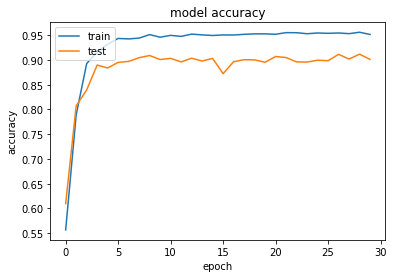

In [ ]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


## Evaluation

In [ ]:
loaded_model1 = load_model("/content/drive/MyDrive/DPProject/Model/model1.h5") 

In [ ]:
# Confusion Matrix
confusion_matrix(y_test, loaded_model1.predict(X_test))

Pred,LAYING,SITTING,STANDING,WALKING,WALKING_DOWNSTAIRS,WALKING_UPSTAIRS
True,,,,,,
LAYING,510,0,27,0,0,0
SITTING,0,415,75,0,0,1
STANDING,0,111,420,1,0,0
WALKING,0,0,0,488,7,1
WALKING_DOWNSTAIRS,0,0,0,25,394,1
WALKING_UPSTAIRS,0,0,0,8,0,463


In [ ]:
score1 = loaded_model1.evaluate(X_test, y_test)
score1[1]

93/93 [==============================] - 0s 4ms/step - loss: 0.2983 - accuracy: 0.9128


0.9127926826477051

In [ ]:
loaded_model2 = load_model("/content/drive/MyDrive/DPProject/Model/model2.h5") 

In [ ]:
confusion_matrix(y_test, loaded_model2.predict(X_test))

Pred,LAYING,SITTING,STANDING,WALKING,WALKING_DOWNSTAIRS,WALKING_UPSTAIRS
True,,,,,,
LAYING,510,0,27,0,0,0
SITTING,6,394,90,0,0,1
STANDING,0,100,431,0,0,1
WALKING,0,0,2,458,9,27
WALKING_DOWNSTAIRS,0,0,0,6,402,12
WALKING_UPSTAIRS,0,0,0,10,0,461


In [ ]:
score2 = loaded_model2.evaluate(X_test, y_test)
score2[1]

93/93 [==============================] - 1s 9ms/step - loss: 0.4709 - accuracy: 0.9013


0.9012554883956909